### Stock Price Prediction 

In [1]:
### Data Collection
import pandas_datareader as pdr
key="ae566c9ef949856e75f2a71fec83c218409d36e3"

In [54]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
df = pdr.get_data_tiingo('AAPL', api_key=key)

C:\Users\jagri\anaconda3\lib\site-packages\pandas_datareader\tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  return pd.concat(dfs, self._concat_axis)


In [4]:
df.to_csv('AAPL.csv')

In [5]:
df=pd.read_csv('AAPL.csv')

In [6]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2019-08-06 00:00:00+00:00,197.00,198.07,194.04,196.31,35824787,47.531668,47.789835,46.817487,47.365187,143299148,0.00,1.0
1,AAPL,2019-08-07 00:00:00+00:00,199.04,199.56,193.82,195.41,33364400,48.023874,48.149339,46.764406,47.148037,133457600,0.00,1.0
2,AAPL,2019-08-08 00:00:00+00:00,203.43,203.53,199.39,200.20,27009523,49.083082,49.107210,48.108321,48.303756,108038092,0.00,1.0
3,AAPL,2019-08-09 00:00:00+00:00,200.99,202.76,199.29,201.30,24619746,48.680149,49.108846,48.268406,48.755232,98478984,0.77,1.0
4,AAPL,2019-08-12 00:00:00+00:00,200.48,202.05,199.15,199.62,22481889,48.556626,48.936883,48.234498,48.348333,89927556,0.00,1.0


In [7]:
print(df.index.min(), df.index.max())

0 1256


In [8]:
df.shape

(1257, 14)

In [9]:
df.isnull().sum()

symbol         0
date           0
close          0
high           0
low            0
open           0
volume         0
adjClose       0
adjHigh        0
adjLow         0
adjOpen        0
adjVolume      0
divCash        0
splitFactor    0
dtype: int64

There is no missing values in the data, we only have to make the data continuous, since the given data does not have prices for weekends and holidays.

In [10]:
#Loading the df as data
data = pd.read_csv('AAPL.csv', parse_dates=['date'], index_col='date')

In [11]:
# Create the full data range for each date
full_date_range = pd.date_range(start=data.index.min(), end=data.index.max())

In [12]:
full_date_range

DatetimeIndex(['2019-08-06 00:00:00+00:00', '2019-08-07 00:00:00+00:00',
               '2019-08-08 00:00:00+00:00', '2019-08-09 00:00:00+00:00',
               '2019-08-10 00:00:00+00:00', '2019-08-11 00:00:00+00:00',
               '2019-08-12 00:00:00+00:00', '2019-08-13 00:00:00+00:00',
               '2019-08-14 00:00:00+00:00', '2019-08-15 00:00:00+00:00',
               ...
               '2024-07-24 00:00:00+00:00', '2024-07-25 00:00:00+00:00',
               '2024-07-26 00:00:00+00:00', '2024-07-27 00:00:00+00:00',
               '2024-07-28 00:00:00+00:00', '2024-07-29 00:00:00+00:00',
               '2024-07-30 00:00:00+00:00', '2024-07-31 00:00:00+00:00',
               '2024-08-01 00:00:00+00:00', '2024-08-02 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=1824, freq='D')

In [13]:
#Reindex the data frame to include all the dates
data_full = data.reindex(full_date_range)

In [14]:
#filling the missing values using forward fill
df1 = data_full.ffill()

In [15]:
#df1 = df1.loc['2020-09-01':'2024-05-24']

In [16]:
df1.head()

,symbol,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
2019-08-06 00:00:00+00:00,AAPL,197.00,198.07,194.04,196.31,35824787.0,47.531668,47.789835,46.817487,47.365187,143299148.0,0.00,1.0
2019-08-07 00:00:00+00:00,AAPL,199.04,199.56,193.82,195.41,33364400.0,48.023874,48.149339,46.764406,47.148037,133457600.0,0.00,1.0
2019-08-08 00:00:00+00:00,AAPL,203.43,203.53,199.39,200.20,27009523.0,49.083082,49.107210,48.108321,48.303756,108038092.0,0.00,1.0
2019-08-09 00:00:00+00:00,AAPL,200.99,202.76,199.29,201.30,24619746.0,48.680149,49.108846,48.268406,48.755232,98478984.0,0.77,1.0
2019-08-10 00:00:00+00:00,AAPL,200.99,202.76,199.29,201.30,24619746.0,48.680149,49.108846,48.268406,48.755232,98478984.0,0.77,1.0


In [17]:
df1.tail()

,symbol,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
2024-07-29 00:00:00+00:00,AAPL,218.24,219.300,215.75,216.96,36311778.0,218.24,219.300,215.75,216.96,36311778.0,0.0,1.0
2024-07-30 00:00:00+00:00,AAPL,218.80,220.325,216.12,219.19,41643840.0,218.80,220.325,216.12,219.19,41643840.0,0.0,1.0
2024-07-31 00:00:00+00:00,AAPL,222.08,223.820,220.63,221.44,50036262.0,222.08,223.820,220.63,221.44,50036262.0,0.0,1.0
2024-08-01 00:00:00+00:00,AAPL,218.36,224.480,217.02,224.37,62500996.0,218.36,224.480,217.02,224.37,62500996.0,0.0,1.0
2024-08-02 00:00:00+00:00,AAPL,219.86,225.600,217.71,219.15,105568560.0,219.86,225.600,217.71,219.15,105568560.0,0.0,1.0


In [18]:
#Using linear interpolation to fill the missing values
data_full_interp = data_full.interpolate(method='linear')

In [19]:
data_full_interp

,symbol,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
2019-08-06 00:00:00+00:00,AAPL,197.00,198.070000,194.040000,196.31,35824787.0,47.531668,47.789835,46.817487,47.365187,143299148.0,0.000000,1.0
2019-08-07 00:00:00+00:00,AAPL,199.04,199.560000,193.820000,195.41,33364400.0,48.023874,48.149339,46.764406,47.148037,133457600.0,0.000000,1.0
2019-08-08 00:00:00+00:00,AAPL,203.43,203.530000,199.390000,200.20,27009523.0,49.083082,49.107210,48.108321,48.303756,108038092.0,0.000000,1.0
2019-08-09 00:00:00+00:00,AAPL,200.99,202.760000,199.290000,201.30,24619746.0,48.680149,49.108846,48.268406,48.755232,98478984.0,0.770000,1.0
2019-08-10 00:00:00+00:00,NaN,200.82,202.523333,199.243333,200.74,23907127.0,48.638975,49.051525,48.257103,48.619599,95628508.0,0.513333,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-29 00:00:00+00:00,AAPL,218.24,219.300000,215.750000,216.96,36311778.0,218.240000,219.300000,215.750000,216.960000,36311778.0,0.000000,1.0
2024-07-30 00:00:00+00:00,AAPL,218.80,220.325000,216.120000,219.19,41643840.0,218.800000,220.325000,216.120000,219.190000,41643840.0,0.000000,1.0
2024-07-31 00:00:00+00:00,AAPL,222.08,223.820000,220.630000,221.44,50036262.0,222.080000,223.820000,220.630000,221.440000,50036262.0,0.000000,1.0
2024-08-01 00:00:00+00:00,AAPL,218.36,224.480000,217.020000,224.37,62500996.0,218.360000,224.480000,217.020000,224.370000,62500996.0,0.000000,1.0


Linear interpolation is a more sophisticated way to fill missing values. BUt forward fill is generally used for financial data. 

In [20]:
# Create a mask for weekends
weekends = (data_full.index.weekday >= 5)

# Forward fill only weekends
data_full_weekends_ffill = data_full.copy()
data_full_weekends_ffill.loc[weekends] = data_full_weekends_ffill.loc[weekends].ffill()

In [21]:
data_full_weekends_ffill

,symbol,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
2019-08-06 00:00:00+00:00,AAPL,197.00,198.070,194.04,196.31,35824787.0,47.531668,47.789835,46.817487,47.365187,143299148.0,0.00,1.0
2019-08-07 00:00:00+00:00,AAPL,199.04,199.560,193.82,195.41,33364400.0,48.023874,48.149339,46.764406,47.148037,133457600.0,0.00,1.0
2019-08-08 00:00:00+00:00,AAPL,203.43,203.530,199.39,200.20,27009523.0,49.083082,49.107210,48.108321,48.303756,108038092.0,0.00,1.0
2019-08-09 00:00:00+00:00,AAPL,200.99,202.760,199.29,201.30,24619746.0,48.680149,49.108846,48.268406,48.755232,98478984.0,0.77,1.0
2019-08-10 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-29 00:00:00+00:00,AAPL,218.24,219.300,215.75,216.96,36311778.0,218.240000,219.300000,215.750000,216.960000,36311778.0,0.00,1.0
2024-07-30 00:00:00+00:00,AAPL,218.80,220.325,216.12,219.19,41643840.0,218.800000,220.325000,216.120000,219.190000,41643840.0,0.00,1.0
2024-07-31 00:00:00+00:00,AAPL,222.08,223.820,220.63,221.44,50036262.0,222.080000,223.820000,220.630000,221.440000,50036262.0,0.00,1.0
2024-08-01 00:00:00+00:00,AAPL,218.36,224.480,217.02,224.37,62500996.0,218.360000,224.480000,217.020000,224.370000,62500996.0,0.00,1.0


In [22]:
data_full_weekends_ffill.loc[weekends]

,symbol,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
2019-08-10 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-11 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-17 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-18 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-24 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-14 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-20 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-21 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-27 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# Calculate the 7-day simple moving average
df1['SMA_7'] = df1['adjClose'].rolling(window=7).mean()

# Calculate the 7-day exponential moving average
df1['EMA_7'] = df1['adjClose'].ewm(span=7, adjust=False).mean()

# Define a function for weighted moving average
def weighted_moving_average(data, window):
    weights = np.arange(1, window + 1)
    wma = data.rolling(window).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
    return wma

# Calculate the 7-day weighted moving average
df1['WMA_7'] = weighted_moving_average(df1['adjClose'], 7)

# Apply Savitzky-Golay filter
df1['savgol'] = savgol_filter(df1['adjClose'], window_length=7, polyorder=2)




In the context of financial data, the adjClose (adjusted closing price) is a commonly used measure because it reflects the stock price after adjustments for all applicable splits and dividend distributions. The adjClose is considered a more accurate reflection of a stock's value over time, making it a good candidate for time series analysis and stationarity testing.

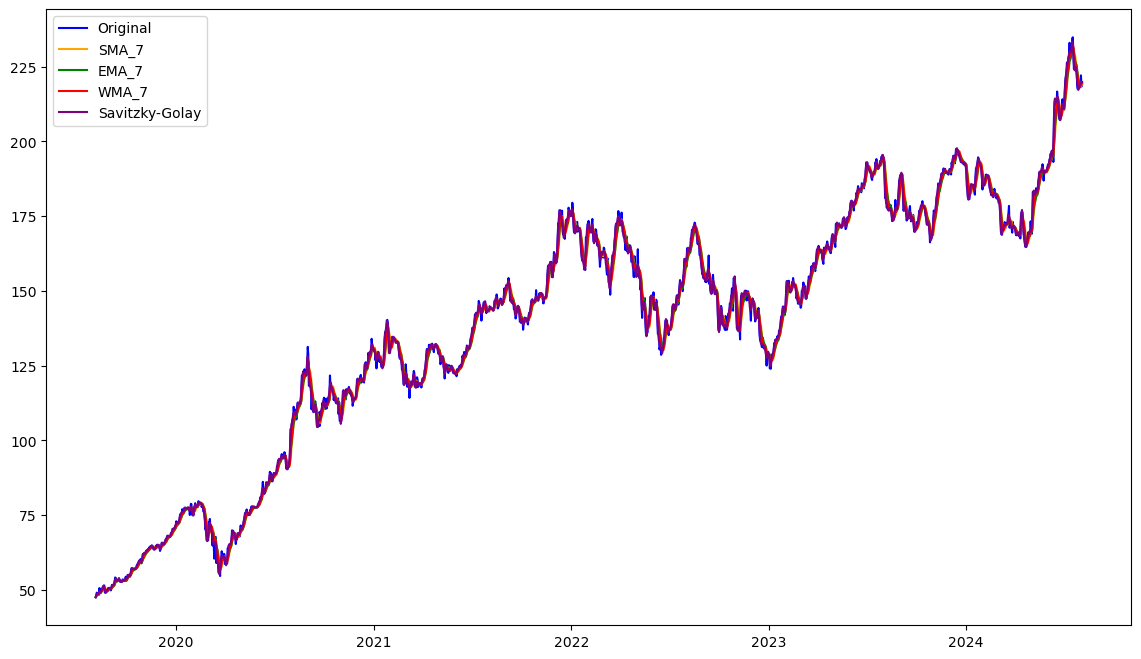

In [24]:
# Plot to visualize
plt.figure(figsize=(14, 8))
plt.plot(df1['adjClose'], label='Original', color='blue')
plt.plot(df1['SMA_7'], label='SMA_7', color='orange')
plt.plot(df1['EMA_7'], label='EMA_7', color='green')
plt.plot(df1['WMA_7'], label='WMA_7', color='red')
plt.plot(df1['savgol'], label='Savitzky-Golay', color='purple')
plt.legend()
plt.show()

In [25]:
df1

,symbol,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor,SMA_7,EMA_7,WMA_7,savgol
2019-08-06 00:00:00+00:00,AAPL,197.00,198.070,194.04,196.31,35824787.0,47.531668,47.789835,46.817487,47.365187,143299148.0,0.00,1.0,NaN,47.531668,NaN,47.584808
2019-08-07 00:00:00+00:00,AAPL,199.04,199.560,193.82,195.41,33364400.0,48.023874,48.149339,46.764406,47.148037,133457600.0,0.00,1.0,NaN,47.654720,NaN,48.177636
2019-08-08 00:00:00+00:00,AAPL,203.43,203.530,199.39,200.20,27009523.0,49.083082,49.107210,48.108321,48.303756,108038092.0,0.00,1.0,NaN,48.011810,NaN,48.590254
2019-08-09 00:00:00+00:00,AAPL,200.99,202.760,199.29,201.30,24619746.0,48.680149,49.108846,48.268406,48.755232,98478984.0,0.77,1.0,NaN,48.178895,NaN,48.822663
2019-08-10 00:00:00+00:00,AAPL,200.99,202.760,199.29,201.30,24619746.0,48.680149,49.108846,48.268406,48.755232,98478984.0,0.77,1.0,NaN,48.304209,NaN,48.598494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-29 00:00:00+00:00,AAPL,218.24,219.300,215.75,216.96,36311778.0,218.240000,219.300000,215.750000,216.960000,36311778.0,0.00,1.0,219.022857,219.383434,218.272857,218.843810
2024-07-30 00:00:00+00:00,AAPL,218.80,220.325,216.12,219.19,41643840.0,218.800000,220.325000,216.120000,219.190000,41643840.0,0.00,1.0,218.135714,219.237576,218.217143,219.373333
2024-07-31 00:00:00+00:00,AAPL,222.08,223.820,220.63,221.44,50036262.0,222.080000,223.820000,220.630000,221.440000,50036262.0,0.00,1.0,218.641429,219.948182,219.203214,219.658571
2024-08-01 00:00:00+00:00,AAPL,218.36,224.480,217.02,224.37,62500996.0,218.360000,224.480000,217.020000,224.370000,62500996.0,0.00,1.0,218.765714,219.551136,219.132857,219.775714


Let us move only with the adjusted closing value of the stock, after applying exponentially moving average (a smoothening process)

In [26]:
df=df1.reset_index()['EMA_7']

In [27]:
df

0        47.531668
1        47.654720
2        48.011810
3        48.178895
4        48.304209
           ...    
1819    219.383434
1820    219.237576
1821    219.948182
1822    219.551136
1823    219.628352
Name: EMA_7, Length: 1824, dtype: float64

In [28]:
# Standardization
scaler_standard = StandardScaler()
df1['std_EMA'] = scaler_standard.fit_transform(df1[['EMA_7']])

In [29]:
df1

,symbol,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor,SMA_7,EMA_7,WMA_7,savgol,std_EMA
2019-08-06 00:00:00+00:00,AAPL,197.00,198.070,194.04,196.31,35824787.0,47.531668,47.789835,46.817487,47.365187,143299148.0,0.00,1.0,NaN,47.531668,NaN,47.584808,-2.144696
2019-08-07 00:00:00+00:00,AAPL,199.04,199.560,193.82,195.41,33364400.0,48.023874,48.149339,46.764406,47.148037,133457600.0,0.00,1.0,NaN,47.654720,NaN,48.177636,-2.141786
2019-08-08 00:00:00+00:00,AAPL,203.43,203.530,199.39,200.20,27009523.0,49.083082,49.107210,48.108321,48.303756,108038092.0,0.00,1.0,NaN,48.011810,NaN,48.590254,-2.133342
2019-08-09 00:00:00+00:00,AAPL,200.99,202.760,199.29,201.30,24619746.0,48.680149,49.108846,48.268406,48.755232,98478984.0,0.77,1.0,NaN,48.178895,NaN,48.822663,-2.129391
2019-08-10 00:00:00+00:00,AAPL,200.99,202.760,199.29,201.30,24619746.0,48.680149,49.108846,48.268406,48.755232,98478984.0,0.77,1.0,NaN,48.304209,NaN,48.598494,-2.126428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-29 00:00:00+00:00,AAPL,218.24,219.300,215.75,216.96,36311778.0,218.240000,219.300000,215.750000,216.960000,36311778.0,0.00,1.0,219.022857,219.383434,218.272857,218.843810,1.918961
2024-07-30 00:00:00+00:00,AAPL,218.80,220.325,216.12,219.19,41643840.0,218.800000,220.325000,216.120000,219.190000,41643840.0,0.00,1.0,218.135714,219.237576,218.217143,219.373333,1.915512
2024-07-31 00:00:00+00:00,AAPL,222.08,223.820,220.63,221.44,50036262.0,222.080000,223.820000,220.630000,221.440000,50036262.0,0.00,1.0,218.641429,219.948182,219.203214,219.658571,1.932315
2024-08-01 00:00:00+00:00,AAPL,218.36,224.480,217.02,224.37,62500996.0,218.360000,224.480000,217.020000,224.370000,62500996.0,0.00,1.0,218.765714,219.551136,219.132857,219.775714,1.922926


# Explorartory data analysis

#### understanding the trends, seasonality, and cyclic behaviour

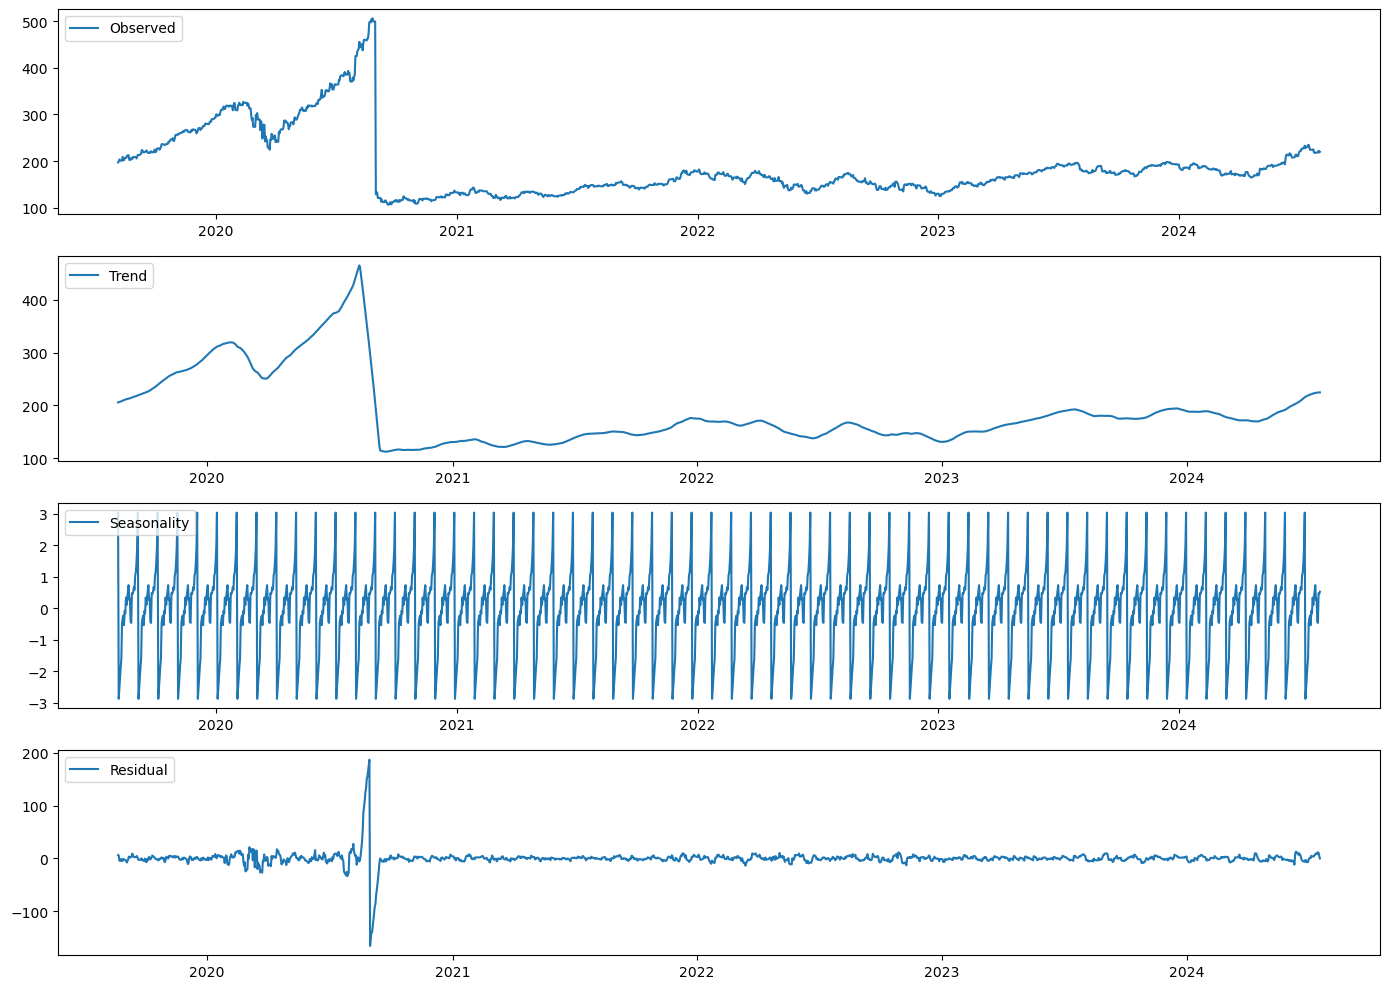

In [30]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(df1['close'], model='additive', period=30)

# Plot the decomposition
plt.figure(figsize=(14, 10))
plt.subplot(4,1,1)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='upper left')
plt.subplot(4,1,2)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(4,1,3)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(4,1,4)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


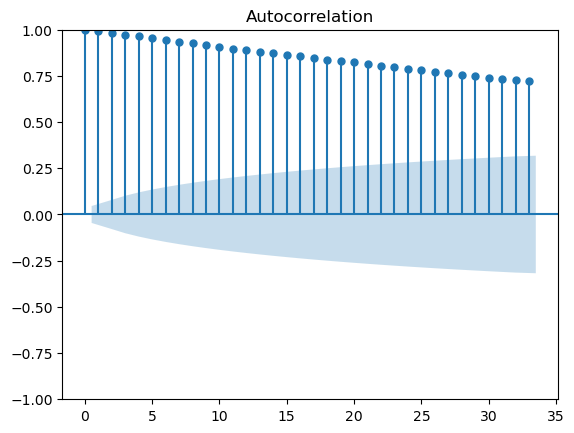

In [31]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df1['close'])
plt.show()


In [32]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1824 entries, 2019-08-06 00:00:00+00:00 to 2024-08-02 00:00:00+00:00
Freq: D
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   symbol       1824 non-null   object 
 1   close        1824 non-null   float64
 2   high         1824 non-null   float64
 3   low          1824 non-null   float64
 4   open         1824 non-null   float64
 5   volume       1824 non-null   float64
 6   adjClose     1824 non-null   float64
 7   adjHigh      1824 non-null   float64
 8   adjLow       1824 non-null   float64
 9   adjOpen      1824 non-null   float64
 10  adjVolume    1824 non-null   float64
 11  divCash      1824 non-null   float64
 12  splitFactor  1824 non-null   float64
 13  SMA_7        1818 non-null   float64
 14  EMA_7        1824 non-null   float64
 15  WMA_7        1818 non-null   float64
 16  savgol       1824 non-null   float64
 17  std_EMA      1824 non-null   float

Time Resampling

In [33]:
#Rule A gives year and frequency 
df1.resample(rule = 'A').min()

,symbol,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor,SMA_7,EMA_7,WMA_7,savgol,std_EMA
2019-12-31 00:00:00+00:00,AAPL,197.00,198.0700,193.820,195.41,11654363.0,47.531668,47.789835,46.764406,47.148037,46617452.0,0.0,1.0,48.462243,47.531668,48.604546,47.584808,-2.144696
2020-12-31 00:00:00+00:00,AAPL,106.84,110.1900,103.100,104.54,20028447.0,54.635258,55.640935,51.771637,55.538663,46691331.0,0.0,1.0,57.372257,57.581109,56.438675,55.358005,-1.907064
2021-12-31 00:00:00+00:00,AAPL,116.36,120.4031,116.210,119.03,40999950.0,114.213962,118.182494,114.066728,116.834719,40999950.0,0.0,1.0,118.041332,118.347097,117.824689,117.178731,-0.470174
2022-12-31 00:00:00+00:00,AAPL,126.04,129.9500,125.870,127.99,35195860.0,125.012914,128.891052,124.844299,126.947024,35195860.0,0.0,1.0,128.835791,129.083710,128.479079,127.494903,-0.216293
2023-12-31 00:00:00+00:00,AAPL,125.02,127.7700,124.170,126.01,24048344.0,124.001226,126.728816,123.158152,124.983158,24048344.0,0.0,1.0,126.849255,126.362355,126.034166,124.907589,-0.280643
2024-12-31 00:00:00+00:00,AAPL,165.00,166.4000,164.075,165.35,34648547.0,164.774959,166.173050,163.851221,165.124482,34648547.0,0.0,1.0,165.884872,166.675465,165.573155,164.709334,0.672613


# Stationarity Check

In [36]:
result = adfuller(df1['EMA_7'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')
    
# Interpretation
if result[1] <= 0.05:
    print("Reject the null hypothesis (H0): The time series is stationary.")
else:
    print("Fail to reject the null hypothesis (H0): The time series is non-stationary.")

ADF Statistic: -1.21390009710988
p-value: 0.6675878412324497
Critical Values:
   1%, -3.4339441475744668
Critical Values:
   5%, -2.8631276157416945
Critical Values:
   10%, -2.5676151930364455
Fail to reject the null hypothesis (H0): The time series is non-stationary.


In [37]:
result = kpss(df1['EMA_7'], regression='c')
print('KPSS Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[3].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

# Interpretation
if result[1] <= 0.05:
    print("Reject the null hypothesis (H0): The time series is stationary.")
else:
    print("Fail to reject the null hypothesis (H0): The time series is non-stationary.")    

KPSS Statistic: 5.564579893957099
p-value: 0.01
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739
Reject the null hypothesis (H0): The time series is stationary.


C:\Users\jagri\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


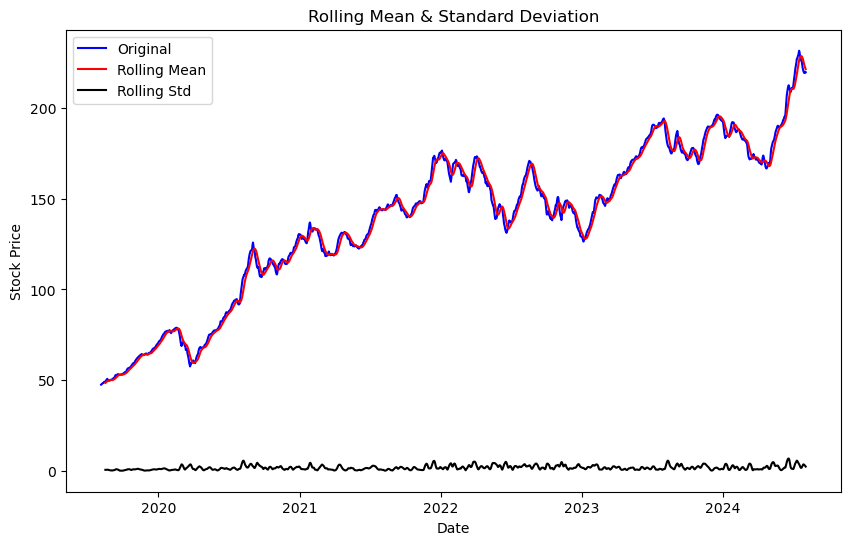

In [38]:
rolling_mean = df1['EMA_7'].rolling(window=12).mean()
rolling_std = df1['EMA_7'].rolling(window=12).std()

plt.figure(figsize=(10, 6))
plt.plot(df1['EMA_7'], color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


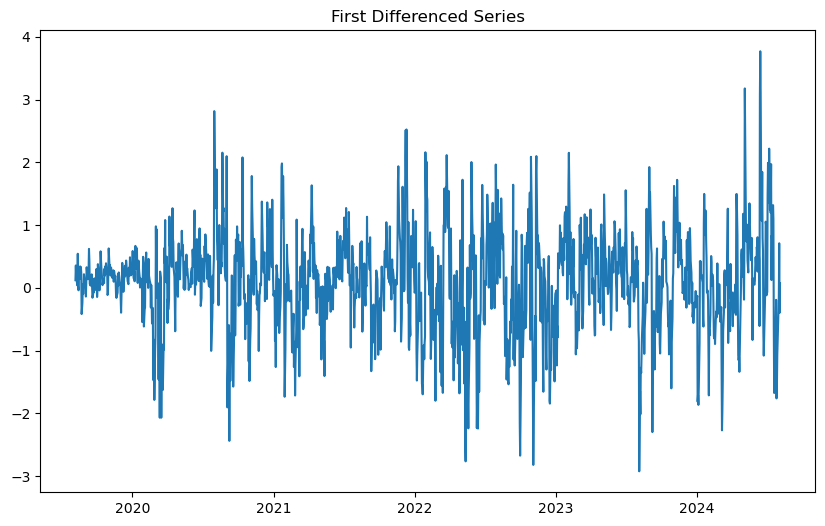

In [39]:
# Differencing
df1['FirstDifference'] = df1['EMA_7'].diff().dropna()
# Plotting the differenced series
plt.figure(figsize=(10, 6))
plt.plot(df1['FirstDifference'])
plt.title('First Differenced Series')
plt.show()

From the first differenced series we can see that now series is stationary.

In [40]:
# Compute first difference and drop NaN values
df1['FirstDifference'] = df1['EMA_7'].diff().dropna()

# Check for NaN or inf values in the first differenced series
if np.any(np.isnan(df1['FirstDifference'])) or np.any(np.isinf(df1['FirstDifference'])):
    # Handle the presence of NaN or inf values appropriately
    df1['FirstDifference'].fillna(method='bfill', inplace=True)  # Example: Filling NaN values with backward fill

# Perform ADF test on the first differenced series
result = adfuller(df1['FirstDifference'])

# Extract and print the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')


ADF Statistic: -16.888619876340687
p-value: 1.0493342741135843e-29
Critical Values:
	1%: -3.4339421732313236
	5%: -2.8631267441543695
	10%: -2.5676147289449824


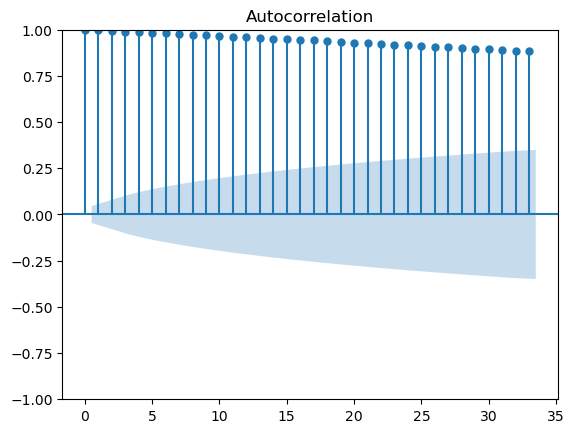

In [41]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df1['adjClose'])
plt.show()

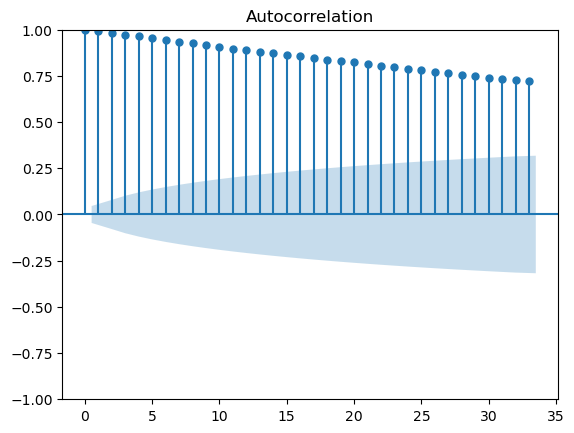

In [42]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df1['close'])
plt.show()

The high and persistent autocorrelation values suggest that the time series is non-stationary. In a stationary series, autocorrelation values typically decrease rapidly towards zero as the lag increases.Such a pattern is often seen in time series with a trend or strong seasonality. In this case, it looks like the time series might have a strong trend component since the autocorrelation does not diminish with increasing lag.

<Figure size 1000x500 with 0 Axes>

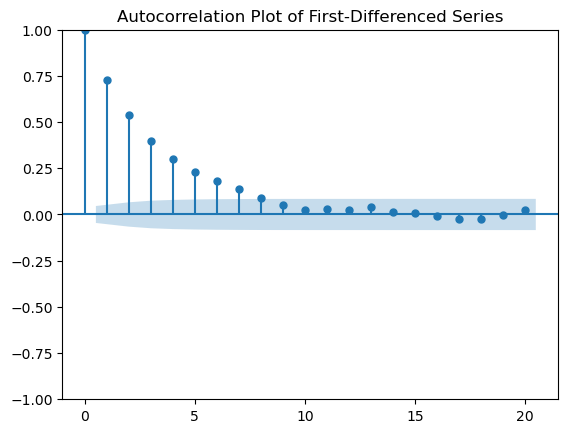

In [43]:
plt.figure(figsize=(10, 5))
plot_acf(df1['FirstDifference'], lags=20)
plt.title('Autocorrelation Plot of First-Differenced Series')
plt.show()

C:\Users\jagri\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1000x500 with 0 Axes>

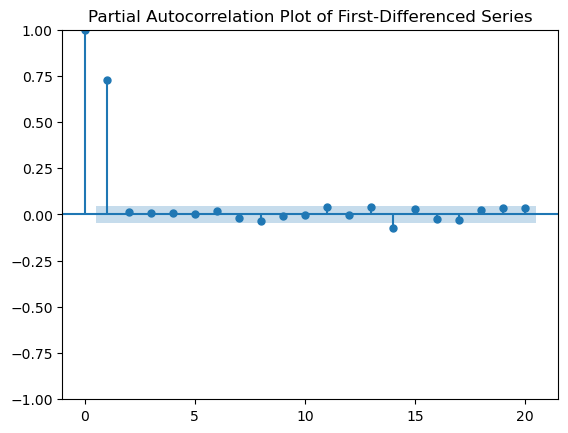

In [44]:
# Plotting the partial autocorrelation plot
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(10, 5))
plot_pacf(df1['FirstDifference'], lags=20)
plt.title('Partial Autocorrelation Plot of First-Differenced Series')
plt.show()

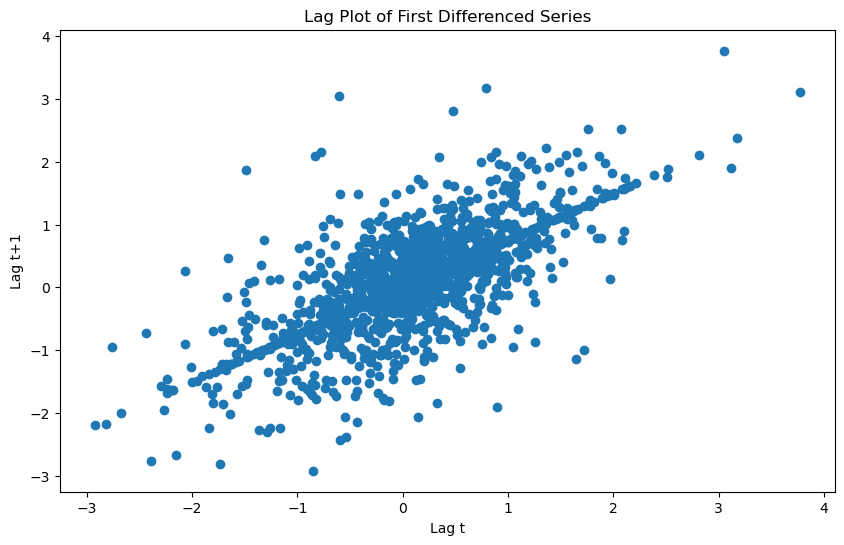

In [45]:
# Lag plot
from pandas.plotting import lag_plot
plt.figure(figsize=(10, 6))
lag_plot(df1['FirstDifference'])
plt.title('Lag Plot of First Differenced Series')
plt.xlabel('Lag t')
plt.ylabel('Lag t+1')
plt.show()

In [46]:
from statsmodels.tsa.arima.model import ARIMA

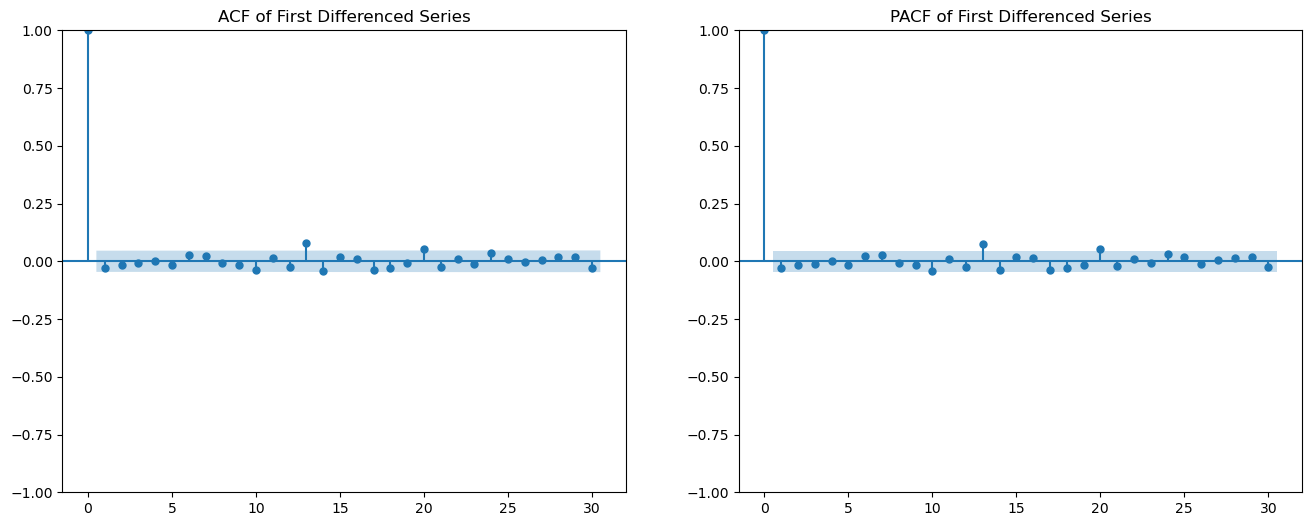

In [47]:
np.random.seed(0)
data2 = pd.DataFrame({'adjClose': np.random.randn(100)})

# First Differencing
df1['FirstDifference'] = df1['adjClose'].diff().dropna()

# Drop the first NA value created by differencing
df1 = df1.dropna()

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(df1['FirstDifference'], lags=30, ax=axes[0])
axes[0].set_title('ACF of First Differenced Series')
plot_pacf(df1['FirstDifference'], lags=30, ax=axes[1])
axes[1].set_title('PACF of First Differenced Series')
plt.show()

In [48]:
model = ARIMA(df1['adjClose'], order=(1, 1, 1))
fitted_model = model.fit()


# Print the model summary
print(fitted_model.summary())


                               SARIMAX Results                                
Dep. Variable:               adjClose   No. Observations:                 1818
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3946.850
Date:                Sun, 04 Aug 2024   AIC                           7899.700
Time:                        09:13:29   BIC                           7916.214
Sample:                    08-12-2019   HQIC                          7905.793
                         - 08-02-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4053      0.594      0.683      0.495      -0.759       1.569
ma.L1         -0.4338      0.591     -0.734      0.463      -1.592       0.724
sigma2         4.5105      0.083     54.238      0.0

In [49]:
model = ARIMA(df1['adjClose'], order=(0, 1, 0))
fitted_model = model.fit()

# Print the model summary
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:               adjClose   No. Observations:                 1818
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -3947.733
Date:                Sun, 04 Aug 2024   AIC                           7897.466
Time:                        09:13:29   BIC                           7902.971
Sample:                    08-12-2019   HQIC                          7899.497
                         - 08-02-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         4.5152      0.081     55.929      0.000       4.357       4.673
Ljung-Box (L1) (Q):                   1.50   Jarque-Bera (JB):              1809.42
Prob(Q):                              0.22   Pr

In [50]:
model = ARIMA(df1['adjClose'], order=(0, 1, 1))
fitted_model = model.fit()

# Print the model summary
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:               adjClose   No. Observations:                 1818
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3947.064
Date:                Sun, 04 Aug 2024   AIC                           7898.128
Time:                        09:13:30   BIC                           7909.138
Sample:                    08-12-2019   HQIC                          7902.191
                         - 08-02-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0276      0.017     -1.584      0.113      -0.062       0.007
sigma2         4.5119      0.083     54.625      0.000       4.350       4.674
Ljung-Box (L1) (Q):                   0.00   Jarque-

C:\Users\jagri\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: UserWarning: Parsing '29/07/2024' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\jagri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\jagri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\jagri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               adjClose   No. Observations:                   52
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -78.840
Date:                Sun, 04 Aug 2024   AIC                            161.680
Time:                        09:16:19   BIC                            165.544
Sample:                    01-31-2019   HQIC                           163.156
                         - 04-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9017      0.066    -13.572      0.000      -1.032      -0.771
sigma2         1.2473      0.252      4.949      0.000       0.753       1.741
Ljung-Box (L1) (Q):                   0.21   Jarque-

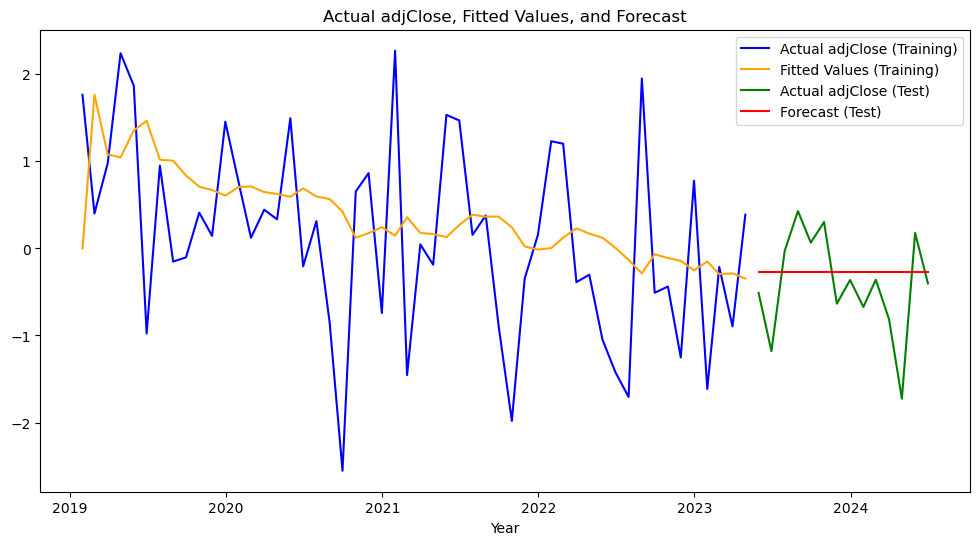

Root Mean Square Error (RMSE): 0.5856652161687507
Mean Absolute Error (MAE): 0.465034916092913


In [55]:
# For demonstration, let's create some synthetic data with a datetime index
date_rng = pd.date_range(start='01/08/2019', end='29/07/2024', freq='M')
np.random.seed(0)
df1 = pd.DataFrame(date_rng, columns=['date'])
df1['adjClose'] = np.random.randn(len(date_rng))
df1 = df1.set_index('date')

# Split the data into training and testing sets
train_size = int(len(df1) * 0.8)
train, test = df1[:train_size], df1[train_size:]

# Fit ARIMA model on training data
p = 0  # Order of the AR term
d = 1  # Order of differencing
q = 1  # Order of the MA term

model = ARIMA(train['adjClose'], order=(p, d, q))
fitted_model = model.fit()

# Print model summary
print(fitted_model.summary())

# Generate fitted values for the training set
fitted_values = fitted_model.fittedvalues

# Forecast the test set
forecast = fitted_model.forecast(steps=len(test))

# Plot actual adjClose, fitted values, and forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['adjClose'], label='Actual adjClose (Training)', color='blue')
plt.plot(train.index, fitted_values, label='Fitted Values (Training)', color='orange')
plt.plot(test.index, test['adjClose'], label='Actual adjClose (Test)', color='green')
plt.plot(test.index, forecast, label='Forecast (Test)', color='red')
plt.title('Actual adjClose, Fitted Values, and Forecast')
plt.xlabel('Year')
plt.legend()
plt.show()

# Calculate RMSE and MAE for the forecast
rmse = np.sqrt(mean_squared_error(test['adjClose'], forecast))
mae = mean_absolute_error(test['adjClose'], forecast)

print(f'Root Mean Square Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')



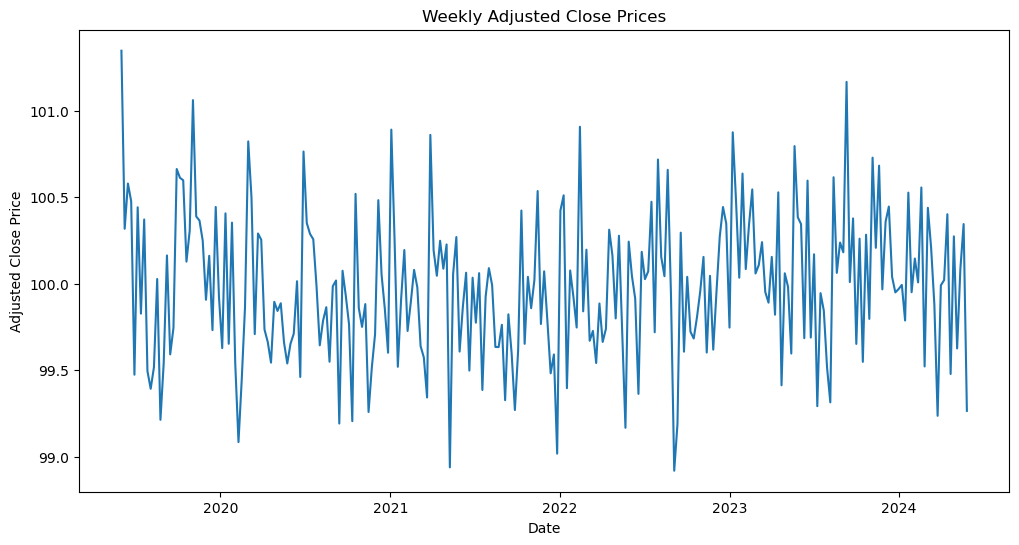

C:\Users\jagri\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                           adjClose   No. Observations:                  208
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 52)   Log Likelihood                -126.978
Date:                            Sun, 04 Aug 2024   AIC                            259.956
Time:                                    09:16:35   BIC                            269.087
Sample:                                06-02-2019   HQIC                           263.665
                                     - 05-21-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9463      0.035    -27.157      0.000      -1.015      -0.878
ma.S.L52      -0.6789      0.205   

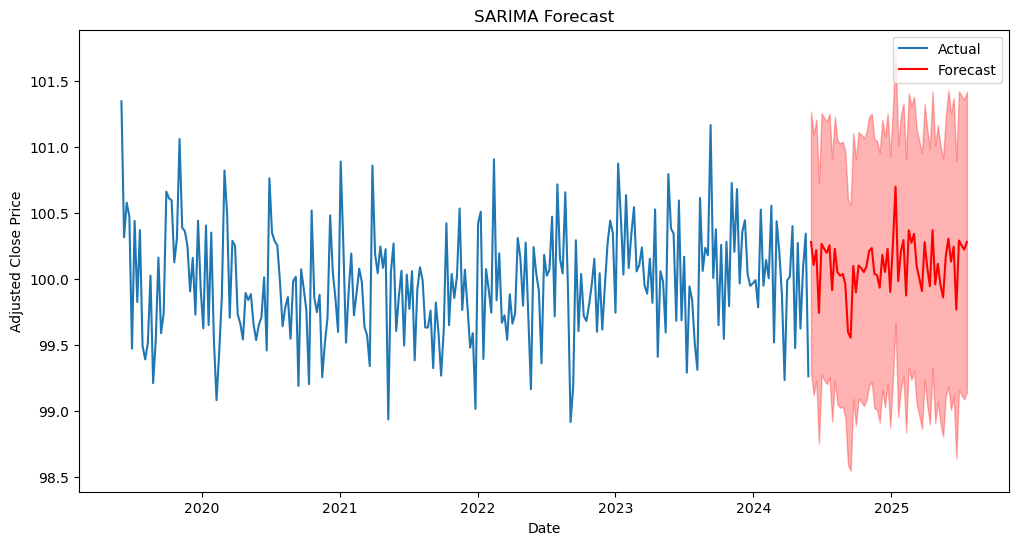

In [56]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

# Generate synthetic daily data for demonstration
date_rng = pd.date_range(start='2019-05-28', end='2024-05-24', freq='B')
np.random.seed(0)
data2 = pd.DataFrame(date_rng, columns=['date'])
data2['adjClose'] = np.random.randn(len(date_rng)) + 100
data2 = data2.set_index('date')

# Downsample the data to weekly frequency
data2_weekly = data2['adjClose'].resample('W').mean()

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(data2_weekly)
plt.title('Weekly Adjusted Close Prices')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.show()

# Split the data into training and testing sets
train_size = int(len(data2_weekly) * 0.8)
train, test = data2_weekly[:train_size], data2_weekly[train_size:]

# Fit SARIMA model on training data
p, d, q = 0, 1, 1
P, D, Q, s = 0, 1, 1, 52  # Seasonal order for yearly seasonality

model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
fitted_model = model.fit(disp=False)

# Print model summary
print(fitted_model.summary())

# Forecast the next 60 periods (weeks in this case)
forecast_steps = 60
forecast = fitted_model.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=test.index[-1], periods=forecast_steps+1, freq='W')[1:]
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plot actual values and forecast
plt.figure(figsize=(12, 6))
plt.plot(data2_weekly.index, data2_weekly, label='Actual')
plt.plot(forecast_index, forecast_values, label='Forecast', color='red')
plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='red', alpha=0.3)
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()
